CSV date range:
  Min date: 2021-01-01 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1058
Rows that have all features = NaN: 21
TRAIN rows: 930
VAL   rows: 107
TEST  rows: 21

=== Training LSTM model ===
[LSTM] Loaded existing model from best_LSTM_S&P_Future_V3.pt
LSTM has no real test data => skip MAPE

=== Training GRU model ===
[GRU] Loaded existing model from best_GRU_S&P_Future_V3.pt
GRU has no real test data => skip MAPE

=== Training RNN model ===
[RNN] Loaded existing model from best_RNN_S&P_Future_V3.pt
RNN has no real test data => skip MAPE

=== Training CNN model ===
[CNN] Loaded existing model from best_CNN_S&P_Future_V3.pt
CNN has no real test data => skip MAPE

=== Training SVM model ===
[SVM] Loaded existing model from best_SVM_S&P_Future_V3.pkl
SVM has no real test data => skip MAPE

=== Training Boost model ===
[Boost] Loaded existing model from best_Boost_S&P_Future_V3.pkl
Boost has no real test data => skip MAPE

=== Training Transformer model ===
[T

/home/yuzhe/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer has no real test data => skip MAPE

=== Training N-BEATS model ===
[N-BEATS] Loaded existing model from best_N-BEATS_S&P_Future_V3.pt
N-BEATS has no real test data => skip MAPE

=== Training N-HITS model ===
[N-HITS] Loaded existing model from best_N-HITS_S&P_Future_V3.pt
N-HITS has no real test data => skip MAPE


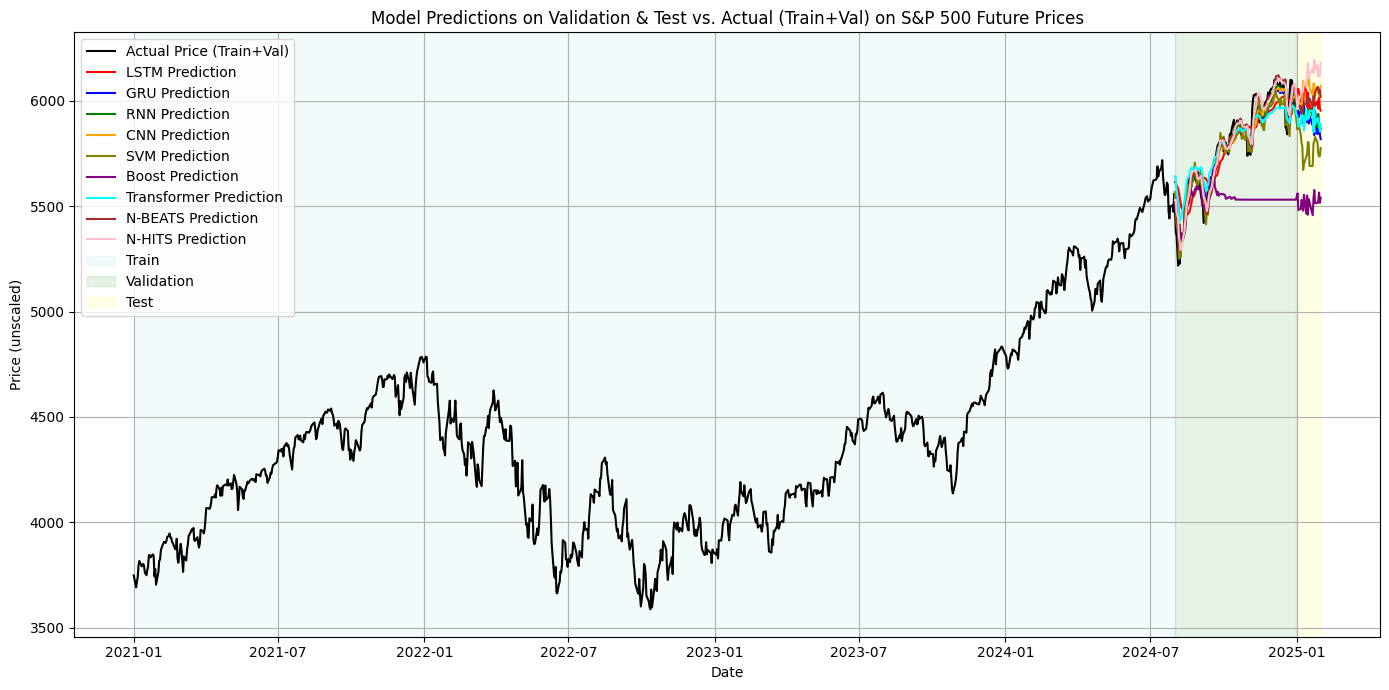

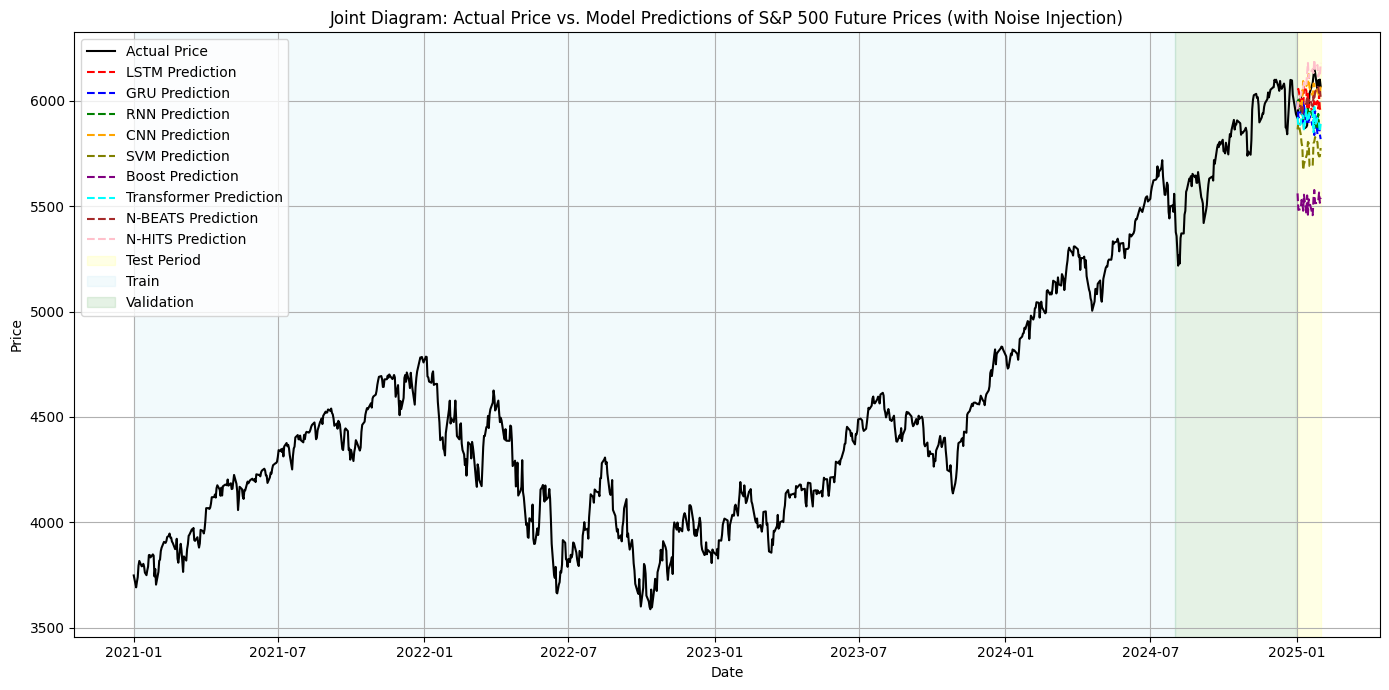

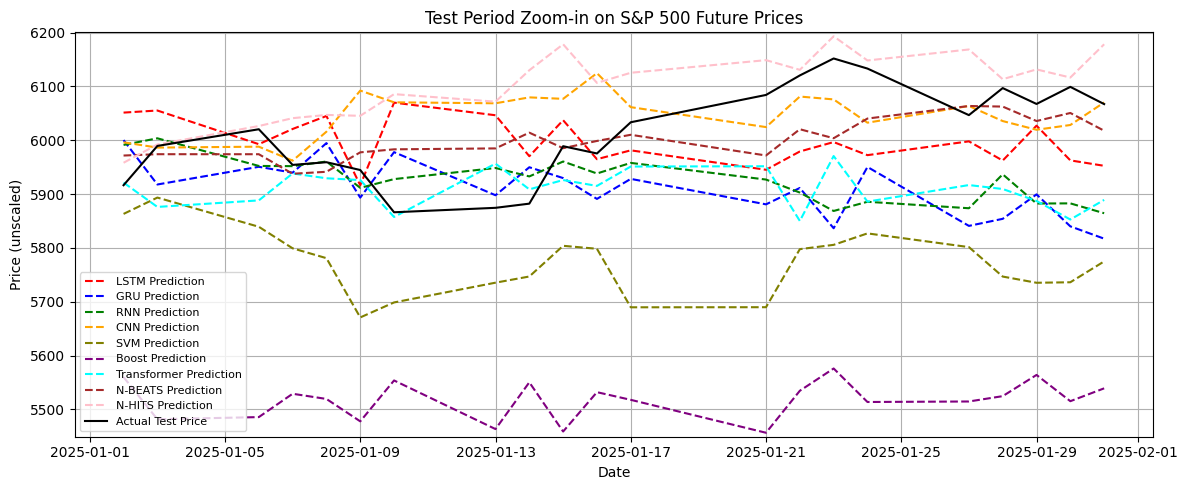

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib

# Additional imports for the appended models:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

###############################################################################
# 1. Set random seeds
###############################################################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################################
# Global hyperparameters
###############################################################################
WINDOW_SIZE = 30
NUM_EPOCHS  = 2000

features = ["Price", "Open", "High", "Low"]
csv_file = "S&P 500 Futures Historical Data.csv"

###############################################################################
# 2. Load & Clean CSV (Gold Prices Data)
###############################################################################
df = pd.read_csv(csv_file)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# ------------------------------------------------------------------------
# 3. Date cutoffs: TRAIN, VAL, TEST
# ------------------------------------------------------------------------
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

###############################################################################
# 4. Fit MinMaxScaler on TRAIN only
###############################################################################
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data (for validation and test walk-forward procedures)
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###############################################################################
# 5A. Create the training sequences
###############################################################################
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=8, prefetch_factor=4)

# For sklearn-based models we flatten the time window.
X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))
# y_train_all remains shape: (n_samples, 4)

###############################################################################
# 5B. "Half-blind" validation loss function (for training)
###############################################################################
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float).values
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

###############################################################################
# 5C. "Half-blind" validation predictions (non-iterative version)
###############################################################################
def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################################
# NEW: Iterative (next-day) half-blind validation predictions
###############################################################################
def iterative_half_blind_validation_preds(model, df_all_scaled, val_start, val_end, window=WINDOW_SIZE):
    """
    Simulates a next-day (iterative) half-blind validation.
    It starts with the final training window (last WINDOW_SIZE rows before val_start),
    then for each validation day:
      - It uses the current window to predict the next day.
      - It then “unveils” the actual observation for that day from df_all_scaled.
      - The window is updated by dropping the oldest row and appending the actual observed row.
    """
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_idx = df_work.index[df_work["Date"] >= val_start]
    if len(val_idx) == 0:
        raise ValueError("No validation data available after val_start.")
    first_val_idx = val_idx[0]
    
    # Initialize current window from the last WINDOW_SIZE rows before validation starts.
    current_window = df_work.iloc[first_val_idx - window:first_val_idx][features].values
    preds = []
    
    val_dates = np.sort(df_work[df_work["Date"] >= val_start]["Date"].unique())
    
    model.eval()
    with torch.no_grad():
        for d in val_dates:
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
            
            # "Uncover" the actual observation for day d.
            actual_row = df_work[df_work["Date"] == d][features].values
            if actual_row.shape[0] == 0:
                continue
            actual = actual_row[0]
            current_window = np.vstack((current_window[1:], actual))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################################
# 6. Define the base PyTorch model (supports several types)
###############################################################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=WINDOW_SIZE):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        
        hidden_size = 128
        
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=hidden_size, num_layers=2,
                               batch_first=True, dropout=0.2)
            self.fc = nn.Linear(hidden_size, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=hidden_size, num_layers=2,
                              batch_first=True, dropout=0.2)
            self.fc = nn.Linear(hidden_size, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=hidden_size, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.2)
            self.fc = nn.Linear(hidden_size, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=hidden_size, num_layers=3,
                               batch_first=True, dropout=0.3)
            self.bn = nn.BatchNorm1d(hidden_size)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(hidden_size, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, hidden_size)
            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=8, dropout=0.2)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(hidden_size, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type in ["LSTM", "GRU", "RNN", "EnhancedLSTM"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            if self.model_type == "EnhancedLSTM":
                out = self.bn(out)
                out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1, 0, 2)
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            out = self.fc(x)
        elif self.model_type in ["N-BEATS", "N-HITS"]:
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

###############################################################################
# Early Stopping class
###############################################################################
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

###############################################################################
# 7. Inverse transform helper
###############################################################################
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

###############################################################################
# 8. Training function for PyTorch models
###############################################################################
def train_model(model_type="LSTM", num_epochs=NUM_EPOCHS):
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)
    
    best_val_loss = float("inf")
    best_path = f"best_{model_type}_S&P_Future_V3.pt"
    
    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            try:
                model.load_state_dict(torch.load(best_path, map_location=device))
                print(f"[{model_type}] Loaded existing model from {best_path}")
            except RuntimeError as e:
                print(f"Error loading checkpoint for {model_type}: {e}. Retraining the model.")
                os.remove(best_path)
    else:
        print(f"No checkpoint found for {model_type}. Training from scratch.")
        
    if not os.path.exists(best_path):
        for epoch in range(num_epochs):
            model.train()
            train_losses = []
            for Xb, yb in train_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                optimizer.zero_grad()
                out = model(Xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            avg_train_loss = np.mean(train_losses)
            val_loss = half_blind_validation_loss(model, df_scaled, val_start=train_cutoff, val_end=val_cutoff, window=WINDOW_SIZE)
            scheduler.step(val_loss)
            early_stopping(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_path)
            if early_stopping.early_stop:
                print(f"[{model_type}] Early stopping at epoch {epoch+1}")
                break
            if (epoch + 1) % 100 == 0:
                print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")
        model.load_state_dict(torch.load(best_path, map_location=device))
    return model

###############################################################################
# 8B. Training function for sklearn-based models (SVM, GPR, Boost)
#     Now with tuning for SVM and Boost (TimeSeriesSplit + GridSearchCV).
###############################################################################
import joblib
import torch
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

class SklearnWrapper:
    """Wraps an sklearn multi-output regressor so it behaves like a PyTorch model."""
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # shape: (1,4) if 4 targets
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    """
    Trains an SVM, GPR, or Boost in multi-output mode using TimeSeriesSplit + GridSearchCV
    for both SVM and Boost. GPR remains single-pass if used.

    NOTE: Adjust 'best_path' as needed per dataset.
    """
    best_path = f"best_{model_type}_S&P_Future_V3.pkl"

    # If a saved model already exists, load it to skip re-training
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
        return SklearnWrapper(model)

    # Otherwise, train/tune from scratch
    print(f"No checkpoint found for {model_type}. Proceeding to train or tune.")

    # Common time-series CV for any model we’re tuning:
    tscv = TimeSeriesSplit(n_splits=3)

    if model_type == "SVM":
        # We now tune SVM hyperparameters
        base_svm = SVR(kernel='rbf')
        param_grid = {
            'estimator__C':       [0.1, 1, 10, 20, 50, 100],
            'estimator__epsilon': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
            'estimator__gamma':   ['scale', 'auto', 0.01]
        }
        multi_est = MultiOutputRegressor(base_svm, n_jobs=-1)

        gsearch = GridSearchCV(
            estimator=multi_est,
            param_grid=param_grid,
            scoring='neg_mean_squared_error',
            cv=tscv,
            n_jobs=-1,
            verbose=1
        )
        gsearch.fit(X_train_flat, y_train)
        best_model = gsearch.best_estimator_
        print("[SVM] Best params:", gsearch.best_params_)

        joblib.dump(best_model, best_path)
        return SklearnWrapper(best_model)

    elif model_type == "Boost":
        # Tuning the Boost model using GridSearchCV with TimeSeriesSplit
        base_gbr = GradientBoostingRegressor(random_state=0)
        param_grid = {
            'estimator__n_estimators': [10, 20, 50, 100, 200],
            'estimator__learning_rate': [0.005, 0.01, 0.05, 0.10],
            'estimator__max_depth': [3, 4, 6, 8]
        }
        multi_est = MultiOutputRegressor(base_gbr, n_jobs=-1)

        gsearch = GridSearchCV(
            estimator=multi_est,
            param_grid=param_grid,
            scoring='neg_mean_squared_error',
            cv=tscv,
            n_jobs=-1,
            verbose=1
        )
        gsearch.fit(X_train_flat, y_train)
        best_model = gsearch.best_estimator_
        print("[Boost] Best params:", gsearch.best_params_)

        joblib.dump(best_model, best_path)
        return SklearnWrapper(best_model)

    elif model_type == "GPR":
        # If you still want GPR as a single-pass
        from sklearn.gaussian_process.kernels import RBF
        from sklearn.gaussian_process import GaussianProcessRegressor
        kernel = RBF(length_scale=1.0)
        base_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
        multi_model = MultiOutputRegressor(base_model)
        multi_model.fit(X_train_flat, y_train)
        joblib.dump(multi_model, best_path)
        return SklearnWrapper(multi_model)

    else:
        raise ValueError("Unsupported sklearn model type: must be SVM, Boost, or GPR.")




###############################################################################
# 9. Test-time walk-forward function with optional noise injection
###############################################################################
def walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE,
                      add_prediction_noise=False, noise_std=0.01):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    model.eval()
    
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]
            
            if add_prediction_noise:
                noise = np.random.normal(0, noise_std, size=y_pred_4_scaled.shape)
                y_pred_4_scaled += noise

            df_work.loc[idx_current, features] = y_pred_4_scaled
            
            preds.append((d, *y_pred_4_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################################
# 10. Evaluate & Plot
###############################################################################
def evaluate_and_plot_all_models(results_dict):
    df_real = df_scaled[["Date", "Price", "Open", "High", "Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:, 0]
    
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")
    
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)
    
    for model_name, info in results_dict.items():
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]
        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if not frames:
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)
        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")
    
    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(model_name, "gray"),
                     linestyle="-",
                     label=f"{model_name} Prediction")
    
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    
    plt.title("Model Predictions on Validation & Test vs. Actual (Train+Val) on S&P 500 Future Prices")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    



###############################################################################
# 11. MAIN
###############################################################################
if __name__ == "__main__":
    # List of all models to run (both PyTorch and sklearn-based)
    # (We exclude SVM, GPR, and Boost here, but you can add them back if you want.)
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "SVM", "Boost", "Transformer", "N-BEATS", "N-HITS"]
    #all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS"]
    
    results_dict = {}
    
    for mt in all_model_types:
        print(f"\n=== Training {mt} model ===")
        if mt in ["SVM", "GPR", "Boost"]:
            model = train_model_sklearn(mt, X_train_flat, y_train_all)
        else:
            model = train_model(mt, num_epochs=NUM_EPOCHS)
        
        # For some models like Transformer, you might do iterative validation
        if mt in ["Transformer"]:  # or "SVM", "Boost"
            val_pred_df = iterative_half_blind_validation_preds(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        else:
            val_pred_df = half_blind_validation_preds_df(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        
        # Do walk-forward test with optional noise injection
        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE,
            add_prediction_noise=True,
            noise_std=0.015
        )
        
        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} has no real test data => skip MAPE")
    
    evaluate_and_plot_all_models(results_dict)

# ================================
# Additional Plot: Joint Diagram
# ================================
df_actual = pd.read_csv("S&P 500 Futures Historical Data_Complete.csv")
df_actual.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
df_actual['Date'] = pd.to_datetime(df_actual['Date'])
df_actual.sort_values(by='Date', ascending=True, inplace=True)
df_actual.reset_index(drop=True, inplace=True)

num_cols = df_actual.columns.drop("Date")
df_actual[num_cols] = df_actual[num_cols].replace({',': ''}, regex=True)
df_actual[num_cols] = df_actual[num_cols].astype('float64')

actual_dates = df_actual['Date']
actual_prices = df_actual['Price']

for model_name, pred_info in results_dict.items():
    if pred_info["test_pred_df"] is not None and not pred_info["test_pred_df"].empty:
        pred_info["test_pred_df"]['Date'] = pd.to_datetime(pred_info["test_pred_df"]['Date'])

plt.figure(figsize=(14, 7))
plt.plot(actual_dates, actual_prices, color='black', linewidth=1.5, label='Actual Price')

model_colors = {
    "LSTM": "red",
    "GRU": "blue",
    "RNN": "green",
    "CNN": "orange",
    "Transformer": "cyan",
    "N-BEATS": "brown",
    "N-HITS": "pink",
    "SVM": "olive",
    "Boost": "purple"
}

for model_name, pred_info in results_dict.items():
    test_df = pred_info["test_pred_df"]
    if test_df is not None and not test_df.empty:
        plt.plot(pd.to_datetime(test_df["Date"]), test_df["Pred_Price_unscaled"],
                 color=model_colors.get(model_name, "gray"),
                 linestyle="--", linewidth=1.5,
                 label=f'{model_name} Prediction')

test_period_start = pd.to_datetime("2025-01-02")
plt.axvspan(test_period_start, actual_dates.iloc[-1], color='yellow', alpha=0.1, label='Test Period')
plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label='Train')
plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label='Validation')

plt.title("Joint Diagram: Actual Price vs. Model Predictions of S&P 500 Future Prices (with Noise Injection)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# ================================
# Additional Cell: Test Period Zoom-in with Actual from "Gold Futures Historical Data_Complete.csv"
# ================================
# 1) Filter out only the test subset from your merged predictions
#    or reconstruct the test subset from your 'results_dict' if needed.
def plot_test_period_zoom(results_dict, df_scaled, test_cutoff):
    # Create a combined DataFrame of predictions from each model during the test period
    # along with the 'Date' column for alignment.
    test_dfs = []
    for model_name, pred_info in results_dict.items():
        if pred_info["test_pred_df"] is not None:
            df_model_test = pred_info["test_pred_df"].copy()
            df_model_test["Date"] = pd.to_datetime(df_model_test["Date"])
            df_model_test.sort_values("Date", inplace=True)
            df_model_test.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}, inplace=True)
            test_dfs.append(df_model_test[["Date", f"Pred_{model_name}"]])
    if not test_dfs:
        print("No test predictions found.")
        return
    
    # Merge all test predictions on the 'Date' column
    from functools import reduce
    merged_test_df = reduce(
        lambda left, right: pd.merge(left, right, on="Date", how="outer"),
        test_dfs
    )
    merged_test_df.sort_values("Date", inplace=True)
    
    # 2) Load the complete CSV with actual unscaled test prices
    try:
        df_complete = pd.read_csv("S&P 500 Futures Historical Data_Complete.csv")
    except FileNotFoundError:
        print("Could not find 'S&P 500 Futures Historical Data_Complete' for actual test overlay.")
        return
    
    df_complete.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"])
    df_complete.sort_values("Date", inplace=True)
    
    # Convert the Price column to float
    df_complete["Price"] = (
        df_complete["Price"]
        .astype(str)
        .str.replace(",", "", regex=True)
        .astype(float)
    )
    
    # 3) Filter the actual test period
    df_test_actual = df_complete[df_complete["Date"] >= test_cutoff].copy()
    
    # 4) Plot each model's prediction
    plt.figure(figsize=(12, 5))
    
    model_colors = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "Boost": "purple"
    }
    
    for model_name, pred_info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_test_df.columns:
            plt.plot(
                merged_test_df["Date"], merged_test_df[col],
                color=model_colors.get(model_name, "gray"),
                linestyle="--",
                label=f"{model_name} Prediction"
            )
    
    # 5) Plot the actual test prices
    plt.plot(df_test_actual["Date"], df_test_actual["Price"],
             color='black', linewidth=1.5, label='Actual Test Price')
    
    # 6) Automatically adjust the y-limits so we see all lines clearly
    all_preds = []
    for model_name, pred_info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_test_df.columns:
            numeric_preds = pd.to_numeric(merged_test_df[col], errors="coerce").dropna()
            all_preds.extend(numeric_preds.tolist())
    
    # Incorporate the actual test prices
    all_preds.extend(df_test_actual["Price"].dropna().values.tolist())
    
    if all_preds:
        min_val, max_val = np.min(all_preds), np.max(all_preds)
        padding = 0.01 * (max_val - min_val)
        plt.ylim(min_val - padding, max_val + padding)
    
    plt.title("Test Period Zoom-in on S&P 500 Future Prices")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend(prop={'size':8})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function with your existing variables:
plot_test_period_zoom(results_dict, df_scaled, test_cutoff)


Model: LSTM - Cumulative Absolute Error: 2055.9556
Model: GRU - Cumulative Absolute Error: 2814.7954
Model: RNN - Cumulative Absolute Error: 2364.6006
Model: CNN - Cumulative Absolute Error: 1664.3818
Model: SVM - Cumulative Absolute Error: 5038.5576
Model: Boost - Cumulative Absolute Error: 10406.0591
Model: Transformer - Cumulative Absolute Error: 2391.3516
Model: N-BEATS - Cumulative Absolute Error: 1228.1113
Model: N-HITS - Cumulative Absolute Error: 1865.4458


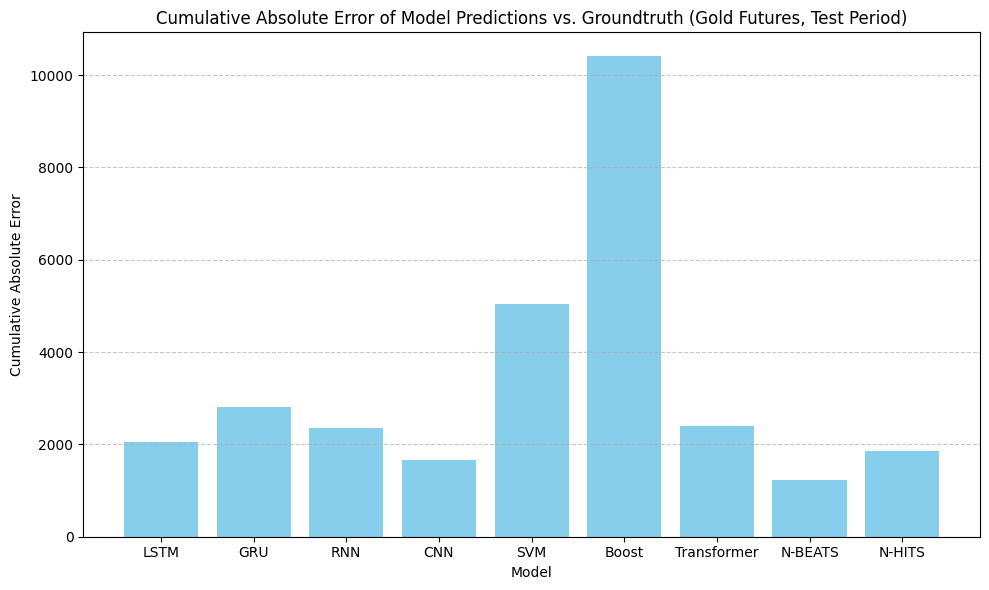

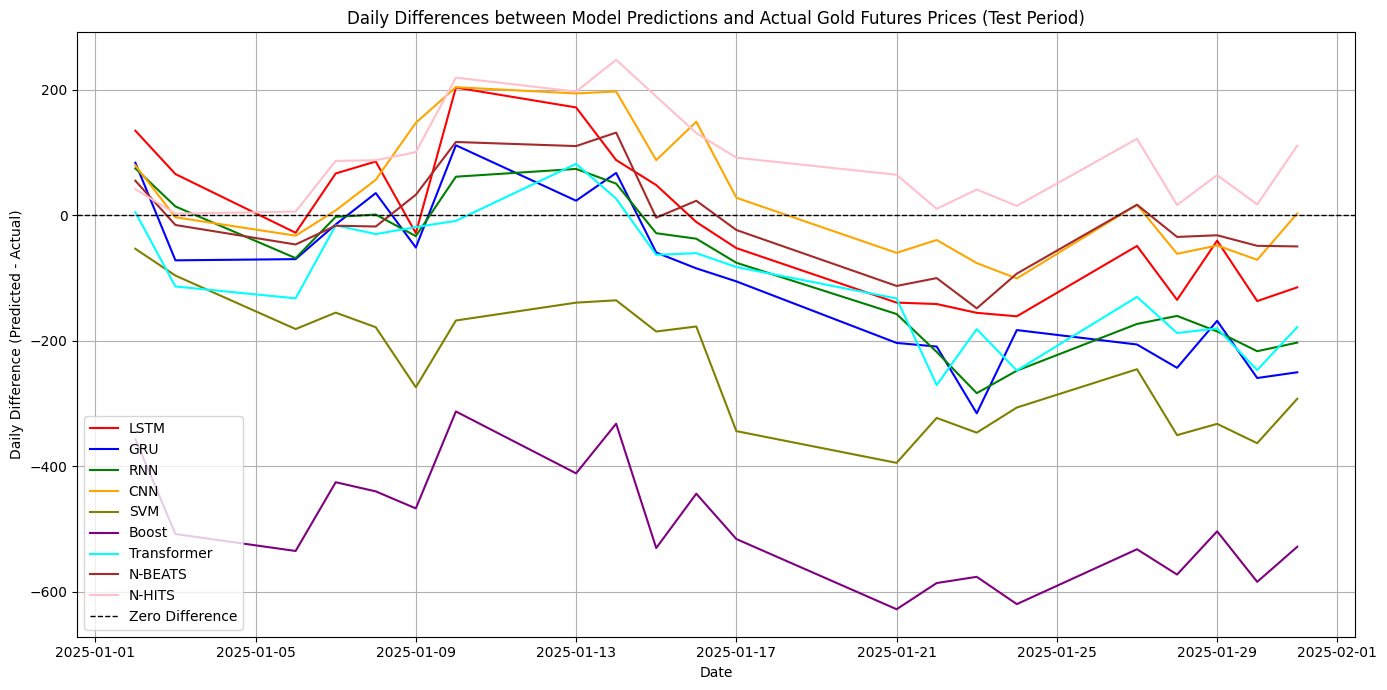


Model Metrics for Trend Matching & Confidence (Gold Futures, Test Period):
         Model  cumulative_error  trend_matching_rate  normalized_error_score  \
0         LSTM       2055.955566                 0.50                0.909801   
1          GRU       2814.795410                 0.55                0.827120   
2          RNN       2364.600586                 0.65                0.876172   
3          CNN       1664.381836                 0.45                0.952465   
4          SVM       5038.557617                 0.65                0.584826   
5        Boost      10406.059082                 0.35                0.000000   
6  Transformer       2391.351562                 0.55                0.873257   
7      N-BEATS       1228.111328                 0.50                1.000000   
8       N-HITS       1865.445801                 0.55                0.930558   

   combined_confidence  
0             0.622940  
1             0.633136  
2             0.717852  
3            

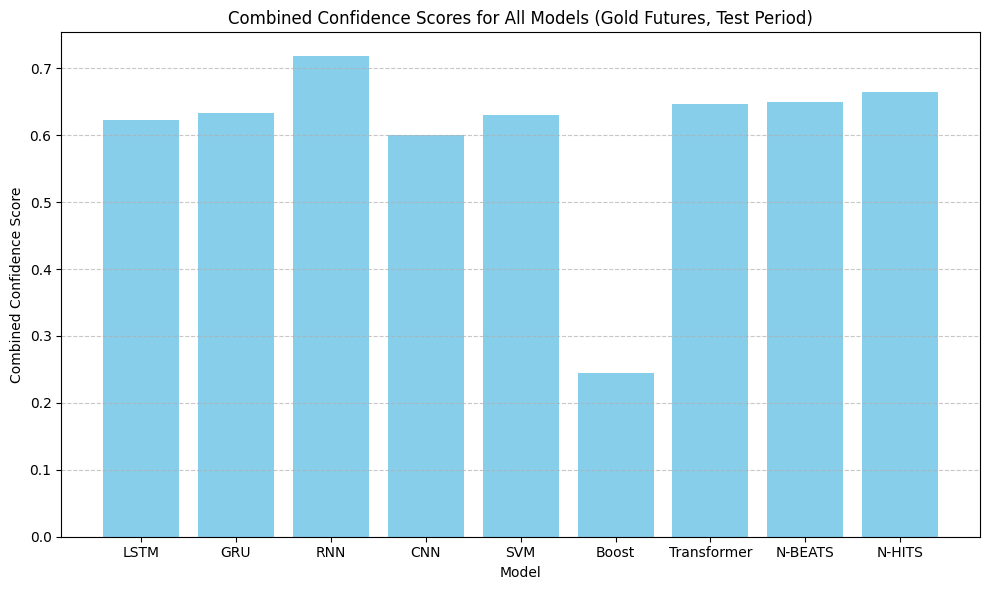


Normalized Confidence Scores for Top 5 Models (Sum = 1):
         Model  normalized_confidence
2          RNN               0.216734
8       N-HITS               0.200526
7      N-BEATS               0.196248
6  Transformer               0.195336
1          GRU               0.191157

Selected Models and Their Normalized Confidence Scores:
{'RNN': 0.21673396917683738, 'N-HITS': 0.20052564657507183, 'N-BEATS': 0.19624821480784232, 'Transformer': 0.19533554376667922, 'GRU': 0.1911566256735693}

Polynomial-fitting DataFrame columns: ['Date', 'Actual', 'RNN', 'N-HITS', 'N-BEATS', 'Transformer', 'GRU']
Number of rows in polynomial-fitting DataFrame: 21

=== Best Polynomial Orders (Gold Futures, Test Window) ===
[Actual] -> Best Degree: 33, Val MSE = 1499.020313
     Polynomial Expression: y = 7.0307e-128*x^33+1.2817e-124*x^32-1.1901e-119*x^31-3.6462e-115*x^30-7.4194e-111*x^29-1.1962e-106*x^28-1.4534e-102*x^27-8.6525e-99*x^26+2.4954e-94*x^25+1.2082e-89*x^24+3.4740e-85*x^23+8.0798e-81*x^22+1

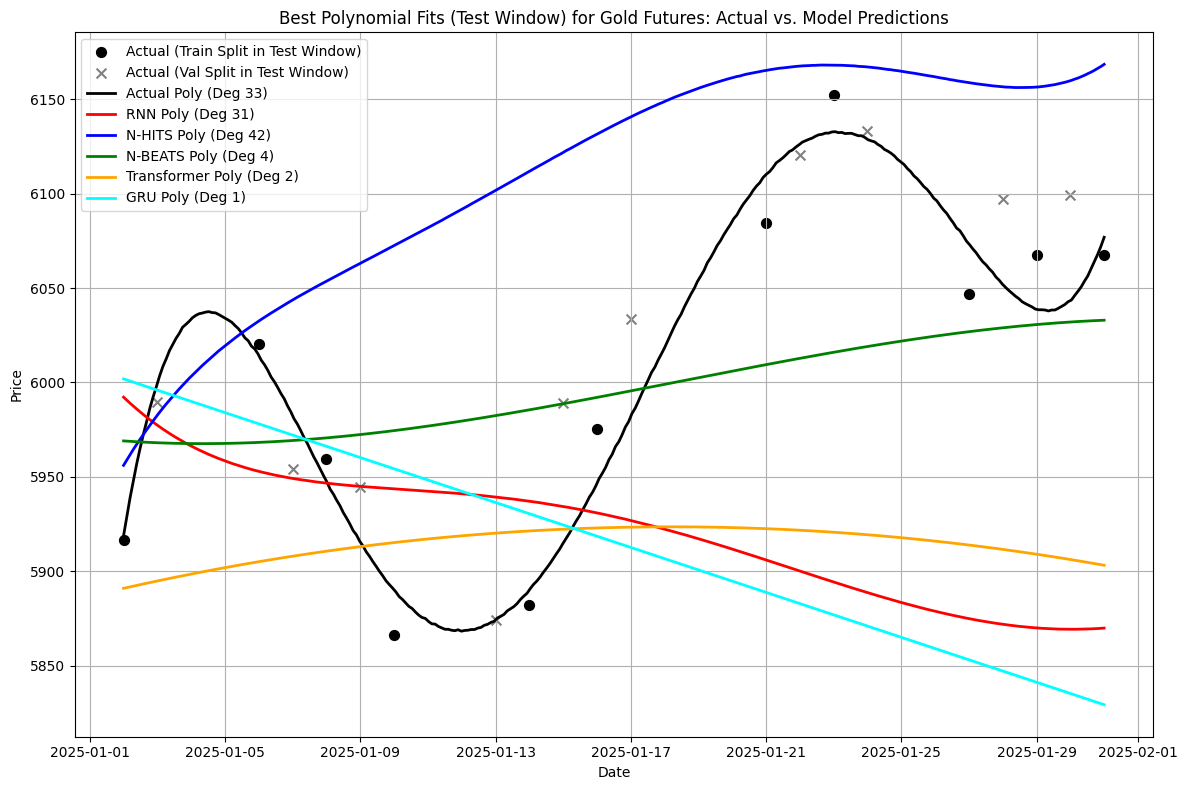

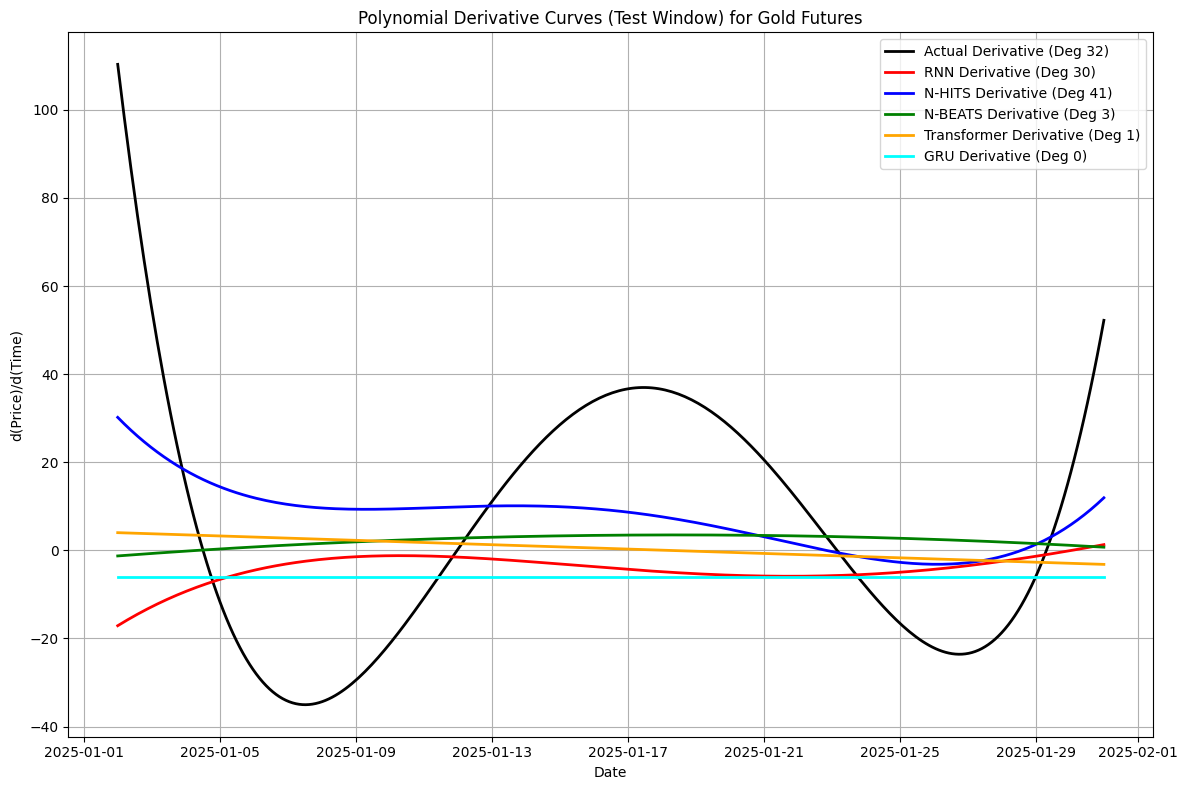


=== Derivative Polynomial Expressions ===
[Actual] (Degree 33) -> derivative: 2.3201e-126*x^32+4.1016e-123*x^31-3.6893e-118*x^30-1.0939e-113*x^29-2.1516e-109*x^28-3.3495e-105*x^27-3.9241e-101*x^26-2.2496e-97*x^25+6.2384e-93*x^24+2.8996e-88*x^23+7.9903e-84*x^22+1.7776e-79*x^21+3.4765e-75*x^20+6.0466e-71*x^19+9.3463e-67*x^18+1.1456e-62*x^17+6.9108e-59*x^16-1.4172e-54*x^15-7.7152e-50*x^14-2.2297e-45*x^13-5.2145e-41*x^12-1.0656e-36*x^11-1.9162e-32*x^10-3.0634e-28*x^9-3.8256e-24*x^8-2.9509e-20*x^7+3.1372e-16*x^6+2.0866e-11*x^5+5.7174e-07*x^4+1.1333e-02*x^3+1.6887e+02*x^2+1.4868e+06*x-3.2202e+09
[RNN] (Degree 31) -> derivative: -3.0313e-119*x^30-2.1968e-116*x^29+5.5763e-111*x^28+1.5041e-106*x^27+2.7679e-102*x^26+3.9658e-98*x^25+3.7402e-94*x^24-5.1470e-91*x^23-1.4975e-85*x^22-4.8175e-81*x^21-1.1701e-76*x^20-2.4025e-72*x^19-4.3305e-68*x^18-6.6438e-64*x^17-7.8457e-60*x^16-4.9897e-56*x^15+1.0504e-51*x^14+5.3984e-47*x^13+1.5553e-42*x^12+3.5952e-38*x^11+6.9835e-34*x^10+1.2171e-29*x^9+1.7337e-25*x

In [2]:
###############################################################################
# Additional Cell: Groundtruth Comparison & Cumulative Absolute Error Calculation
###############################################################################
import warnings
warnings.filterwarnings("ignore")  # Ignore all warning messages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load groundtruth actual test prices from the complete CSV for Gold Futures
df_groundtruth = pd.read_csv("S&P 500 Futures Historical Data_Complete.csv")
df_groundtruth.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
df_groundtruth['Date'] = pd.to_datetime(df_groundtruth['Date'])
df_groundtruth.sort_values("Date", inplace=True)
df_groundtruth.reset_index(drop=True, inplace=True)

# Convert columns to numeric if needed
num_cols = df_groundtruth.columns.drop("Date")
df_groundtruth[num_cols] = df_groundtruth[num_cols].replace({',': ''}, regex=True)
df_groundtruth[num_cols] = df_groundtruth[num_cols].astype(float)

# Filter the data to only include the test period (dates >= test_cutoff)
df_groundtruth_test = df_groundtruth[df_groundtruth["Date"] >= test_cutoff][["Date", "Price"]].copy()

# Dictionary to store cumulative absolute errors for each model (excluding SVM, GPR, Boost from the plot)
cumulative_errors = {}

# Iterate through each model's test predictions in the results_dict
for model_name, info in results_dict.items():
    # Skip if we do not want to show SVM, GPR, or Boost in the plots
    #if model_name in ["SVM", "GPR", "Boost"]:
        #continue
    
    test_pred_df = info.get("test_pred_df")
    if test_pred_df is not None and not test_pred_df.empty:
        # Ensure the Date column is datetime format
        test_pred_df["Date"] = pd.to_datetime(test_pred_df["Date"])
        # Merge the model's predictions with the groundtruth data on Date
        df_merge = pd.merge(test_pred_df, df_groundtruth_test, on="Date", how="inner")
        if not df_merge.empty:
            # Calculate the absolute error between the predicted unscaled price and the actual price
            df_merge["Abs_Error"] = np.abs(df_merge["Pred_Price_unscaled"] - df_merge["Price"])
            # Sum the absolute errors over the test period to get cumulative error
            cumulative_error = df_merge["Abs_Error"].sum()
            cumulative_errors[model_name] = cumulative_error
            print(f"Model: {model_name} - Cumulative Absolute Error: {cumulative_error:.4f}")
        else:
            print(f"Model: {model_name} - No matching dates with groundtruth for the test period.")
    else:
        print(f"Model: {model_name} - No test predictions available.")

# Plot the cumulative absolute errors as a bar chart (excluding SVM/GPR/Boost)
if cumulative_errors:
    plt.figure(figsize=(10, 6))
    model_names = list(cumulative_errors.keys())
    errors = [cumulative_errors[m] for m in model_names]
    plt.bar(model_names, errors, color='skyblue')
    plt.xlabel("Model")
    plt.ylabel("Cumulative Absolute Error")
    plt.title("Cumulative Absolute Error of Model Predictions vs. Groundtruth (Gold Futures, Test Period)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

###############################################################################
# Additional Cell: Daily Difference Diagram (Predicted - Actual)
###############################################################################
plt.figure(figsize=(14, 7))
model_colors = {
    "LSTM": "red",
    "GRU": "blue",
    "RNN": "green",
    "CNN": "orange",
    "Transformer": "cyan",
    "N-BEATS": "brown",
    "N-HITS": "pink",
    "SVM": "olive",
    "Boost": "purple",
}

# Iterate through each model in results_dict (excluding SVM/GPR/Boost from the difference plot)
for model_name, info in results_dict.items():
    #if model_name in ["SVM", "GPR", "Boost"]:
        #continue
    
    test_pred_df = info.get("test_pred_df")
    if test_pred_df is None or test_pred_df.empty:
        continue
    
    # Ensure Date column is datetime format
    test_pred_df["Date"] = pd.to_datetime(test_pred_df["Date"])
    # Merge with groundtruth based on Date
    df_merge = pd.merge(test_pred_df, df_groundtruth_test, on="Date", how="inner")
    if df_merge.empty:
        continue
    
    df_merge.sort_values("Date", inplace=True)
    # Calculate daily difference: predicted unscaled price minus actual price
    df_merge["Difference"] = df_merge["Pred_Price_unscaled"] - df_merge["Price"]
    color = model_colors.get(model_name, None)
    plt.plot(df_merge["Date"], df_merge["Difference"], label=model_name, color=color)

# Draw a horizontal line at zero difference
plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Difference")
plt.xlabel("Date")
plt.ylabel("Daily Difference (Predicted - Actual)")
plt.title("Daily Differences between Model Predictions and Actual Gold Futures Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###############################################################################
# Additional Cell: Model Selection Based on Trend Matching & Confidence Score
###############################################################################
df_groundtruth_test = df_groundtruth[df_groundtruth["Date"] >= test_cutoff][["Date", "Price"]].copy()

# Dictionary to store metrics for each model
model_metrics = {}

# Iterate through each model (excluding SVM/GPR/Boost) in results_dict
for model_name, info in results_dict.items():
    #if model_name in ["SVM", "GPR", "Boost"]:
        #continue
    
    test_pred_df = info.get("test_pred_df")
    if test_pred_df is None or test_pred_df.empty:
        print(f"Model: {model_name} - No test predictions available.")
        continue
    # Ensure Date column is datetime type
    test_pred_df["Date"] = pd.to_datetime(test_pred_df["Date"])
    # Merge model predictions with groundtruth data on Date
    df_merge = pd.merge(test_pred_df, df_groundtruth_test, on="Date", how="inner")
    if df_merge.empty:
        print(f"Model: {model_name} - No matching dates with groundtruth for the test period.")
        continue
    # Sort by Date to ensure proper chronological order
    df_merge.sort_values("Date", inplace=True)
    
    # --- Metric 1: Cumulative Absolute Error ---
    df_merge["Abs_Error"] = np.abs(df_merge["Pred_Price_unscaled"] - df_merge["Price"])
    cumulative_error = df_merge["Abs_Error"].sum()
    
    # --- Metric 2: Trend Matching Rate ---
    # Calculate day-to-day differences for actual and predicted prices
    df_merge["Actual_Diff"] = df_merge["Price"].diff()
    df_merge["Pred_Diff"]   = df_merge["Pred_Price_unscaled"].diff()
    df_valid = df_merge.dropna(subset=["Actual_Diff", "Pred_Diff"]).copy()
    
    def sign_match(a, b):
        if a == 0 and b == 0:
            return 1
        return 1 if np.sign(a) == np.sign(b) else 0
    
    df_valid["Trend_Match"] = df_valid.apply(lambda row: sign_match(row["Actual_Diff"], row["Pred_Diff"]), axis=1)
    if len(df_valid) > 0:
        trend_matching_rate = df_valid["Trend_Match"].mean()
    else:
        trend_matching_rate = 0.0
    
    model_metrics[model_name] = {
        "cumulative_error": cumulative_error,
        "trend_matching_rate": trend_matching_rate
    }

# Normalize the Cumulative Error and compute Combined Confidence Score
if model_metrics:
    cum_errors = [metrics["cumulative_error"] for metrics in model_metrics.values()]
    min_error = min(cum_errors)
    max_error = max(cum_errors)
    
    for model_name, metrics in model_metrics.items():
        if max_error > min_error:
            normalized_error_score = 1 - ((metrics["cumulative_error"] - min_error) / (max_error - min_error))
        else:
            normalized_error_score = 1  # all models have identical errors
        model_metrics[model_name]["normalized_error_score"] = normalized_error_score
        
        # Weighted combination: 70% trend match + 30% normalized error
        combined_confidence = 0.7 * metrics["trend_matching_rate"] + 0.3 * normalized_error_score
        model_metrics[model_name]["combined_confidence"] = combined_confidence

# Convert the metrics dictionary into a DataFrame for easier viewing
df_metrics = pd.DataFrame.from_dict(model_metrics, orient="index")
df_metrics.reset_index(inplace=True)
df_metrics.rename(columns={"index": "Model"}, inplace=True)

print("\nModel Metrics for Trend Matching & Confidence (Gold Futures, Test Period):")
print(df_metrics)

# --- Select Top 5 Models Based on Combined Confidence ---
top5_models = df_metrics.sort_values("combined_confidence", ascending=False).head(5)
print("\nTop 5 Selected Models:")
print(top5_models)

# --- Plot Combined Confidence Scores ---
plt.figure(figsize=(10, 6))
model_names = df_metrics["Model"].tolist()
confidence_scores = df_metrics["combined_confidence"].tolist()
plt.bar(model_names, confidence_scores, color='skyblue')
plt.xlabel("Model")
plt.ylabel("Combined Confidence Score")
plt.title("Combined Confidence Scores for All Models (Gold Futures, Test Period)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

###############################################################################
# Additional Cell: Re-normalize Confidence Scores for Top N Models
###############################################################################
if not top5_models.empty:
    total_confidence = top5_models["combined_confidence"].sum()
    top5_models["normalized_confidence"] = top5_models["combined_confidence"] / total_confidence
    print("\nNormalized Confidence Scores for Top 5 Models (Sum = 1):")
    print(top5_models[["Model", "normalized_confidence"]])
    
    # Dictionary of selected models & their normalized confidences
    selected_models_confidence = dict(zip(top5_models["Model"], top5_models["normalized_confidence"]))
    print("\nSelected Models and Their Normalized Confidence Scores:")
    print(selected_models_confidence)
else:
    print("\nNo top models available to normalize confidence scores.")

###############################################################################
# Additional Cell: Polynomial Fitting & Gradients in Test Window
###############################################################################
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

# 1) Gather Test Data: Actual vs. Top Models' Predictions
# Create a DataFrame from the groundtruth test data
df_test_poly = df_groundtruth_test.rename(columns={"Price": "Actual"}).copy()
df_test_poly.sort_values("Date", inplace=True)

# Only keep the top models from selected_models_confidence (or fallback to all if none)
if 'selected_models_confidence' in globals() and selected_models_confidence:
    best_model_names = list(selected_models_confidence.keys())
else:
    # If no selected_models_confidence, fallback to all models (excluding SVM/GPR/Boost)
    best_model_names = [
        m for m in results_dict.keys()
        if m not in ["SVM", "GPR", "Boost"]
    ]

# Merge each model's predictions (assumed in "Pred_Price_unscaled") into df_test_poly
for model_name in best_model_names:
    pred_df = results_dict[model_name]["test_pred_df"]
    if pred_df is not None and not pred_df.empty:
        pred_df["Date"] = pd.to_datetime(pred_df["Date"])
        df_test_poly = pd.merge(
            df_test_poly,
            pred_df[["Date", "Pred_Price_unscaled"]],
            on="Date", how="left"
        ).rename(columns={"Pred_Price_unscaled": model_name})

# Drop rows with missing data in any column
df_test_poly.dropna(axis=0, how="any", inplace=True)
df_test_poly.reset_index(drop=True, inplace=True)

print("\nPolynomial-fitting DataFrame columns:", df_test_poly.columns.tolist())
print("Number of rows in polynomial-fitting DataFrame:", len(df_test_poly))

# 2) Create Train/Validation Masks (e.g., even-index rows for training, odd-index for validation)
n_points = len(df_test_poly)
indices = np.arange(n_points)
training_mask = (indices % 2 == 0)
validation_mask = ~training_mask

# Convert dates to a numeric axis for polynomial fitting
df_test_poly["mdates_num"] = mdates.date2num(df_test_poly["Date"])

# 3) For Each Column, Select Best Polynomial Degree (1 to 70)
def format_polynomial(coeffs):
    """Convert polynomial coefficients into a readable expression."""
    terms = []
    degree = len(coeffs) - 1
    for i, c in enumerate(coeffs):
        power = degree - i
        if power > 1:
            terms.append(f"{c:+.4e}*x^{power}")
        elif power == 1:
            terms.append(f"{c:+.4e}*x")
        else:
            terms.append(f"{c:+.4e}")
    expr = "".join(terms).replace("+-", "-")
    if expr.startswith("+"):
        expr = expr[1:]
    return expr

best_poly_info = {}
poly_degree_candidates = range(1, 70)
columns_to_fit = ["Actual"] + best_model_names

for col in columns_to_fit:
    x_train = df_test_poly.loc[training_mask, "mdates_num"].values
    y_train = df_test_poly.loc[training_mask, col].values
    x_val   = df_test_poly.loc[validation_mask, "mdates_num"].values
    y_val   = df_test_poly.loc[validation_mask, col].values
    
    best_val_mse = float("inf")
    best_degree = None
    best_coeffs = None
    for d in poly_degree_candidates:
        coeffs = np.polyfit(x_train, y_train, d)
        y_val_pred = np.polyval(coeffs, x_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_degree = d
            best_coeffs = coeffs
    best_poly_info[col] = {"degree": best_degree, "coeffs": best_coeffs, "val_mse": best_val_mse}

# 4) Print Each Column's Best Polynomial Info
print("\n=== Best Polynomial Orders (Gold Futures, Test Window) ===")
for col in columns_to_fit:
    info = best_poly_info[col]
    deg = info["degree"]
    mse = info["val_mse"]
    coeffs = info["coeffs"]
    expr = format_polynomial(coeffs)
    print(f"[{col}] -> Best Degree: {deg}, Val MSE = {mse:.6f}")
    print(f"     Polynomial Expression: y = {expr}\n")

# 5) Joint Plot: Overlay Best-Fitting Polynomial Curves for All Columns
plt.figure(figsize=(12, 8))
# Plot actual data points, highlighting training vs validation
plt.scatter(df_test_poly.loc[training_mask, "Date"], df_test_poly.loc[training_mask, "Actual"],
            color="black", marker="o", s=50, label="Actual (Train Split in Test Window)")
plt.scatter(df_test_poly.loc[validation_mask, "Date"], df_test_poly.loc[validation_mask, "Actual"],
            color="gray", marker="x", s=50, label="Actual (Val Split in Test Window)")

# Define colors for polynomials (use the same color map)
colors_for_poly = {
    "Actual": "black",
}
default_colors = ["red", "blue", "green", "orange", "cyan", "brown", "pink"]
for i, model_name in enumerate(best_model_names):
    colors_for_poly[model_name] = default_colors[i % len(default_colors)]

# Create a dense x-axis for polynomial evaluation
x_dense = np.linspace(df_test_poly["mdates_num"].min(), df_test_poly["mdates_num"].max(), 300)
x_dense_dates = [mdates.num2date(xx) for xx in x_dense]

# Plot each column's polynomial
for col in columns_to_fit:
    info = best_poly_info[col]
    coeffs = info["coeffs"]
    y_dense = np.polyval(coeffs, x_dense)
    plt.plot(x_dense_dates, y_dense,
             color=colors_for_poly.get(col, "gray"), linewidth=2,
             label=f"{col} Poly (Deg {info['degree']})")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Best Polynomial Fits (Test Window) for Gold Futures: Actual vs. Model Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6) (Optional) Derivative Curves & Their Expressions
def derivative_expression(coeffs):
    d_coeffs = np.polyder(coeffs)
    return format_polynomial(d_coeffs)

plt.figure(figsize=(12, 8))
for col in columns_to_fit:
    info = best_poly_info[col]
    d_coeffs = np.polyder(info["coeffs"])
    y_deriv = np.polyval(d_coeffs, x_dense)
    plt.plot(x_dense_dates, y_deriv,
             color=colors_for_poly.get(col, "gray"), linewidth=2,
             label=f"{col} Derivative (Deg {info['degree']-1})")

plt.xlabel("Date")
plt.ylabel("d(Price)/d(Time)")
plt.title("Polynomial Derivative Curves (Test Window) for Gold Futures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n=== Derivative Polynomial Expressions ===")
for col in columns_to_fit:
    info = best_poly_info[col]
    d_expr = derivative_expression(info["coeffs"])
    print(f"[{col}] (Degree {info['degree']}) -> derivative: {d_expr}")
